In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys
import matplotlib

sys_epsilon = sys.float_info.epsilon
matplotlib.rcParams['font.family'] = 'Serif'
matplotlib.rcParams['font.size'] = 14

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_rest_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_rest_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_rest_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103_means = pd.read_csv('./datasets/fieldData_rest_R103_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_means = pd.read_csv('./datasets/fieldData_rest_R503_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_means = pd.read_csv('./datasets/fieldData_rest_R104_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

R103_scales = pd.read_csv('./datasets/fieldData_rest_R103_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_scales = pd.read_csv('./datasets/fieldData_rest_R503_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_scales = pd.read_csv('./datasets/fieldData_rest_R104_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

In [4]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000178,-0.000519,0.002788,-0.001416,-0.000398,0.000795,0.001038,-0.001166,0.000107,...,-0.001166,0.000361,-0.000233,-0.133664,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.219229
1,-1.027122,0.007117,-0.001178,0.002198,0.005526,-0.000435,0.000753,0.001038,-0.005757,0.000106,...,-0.005757,0.000359,-0.004720,-0.133664,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.184253
2,-1.027122,0.032932,-0.002102,0.001278,0.017426,-0.000476,0.000689,0.001038,-0.012206,0.000101,...,-0.012206,0.000352,-0.011717,-0.133658,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.184228
3,-1.027122,0.081009,-0.002795,0.000454,0.027343,-0.000304,0.000835,0.001038,-0.017039,0.000095,...,-0.017039,0.000342,-0.017983,-0.133624,-0.011825,0.009136,-0.152857,-0.045876,-0.14981,-0.183919
4,-1.027122,0.131517,-0.001906,0.001049,0.017426,0.000068,0.001191,0.001038,-0.010835,0.000099,...,-0.010835,0.000348,-0.013454,-0.133530,-0.011827,0.009135,-0.152857,-0.045876,-0.14981,-0.181174


In [5]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(38031441, 23)

In [6]:
M1_names = [r'$U_x$', r'$U_y$', r'$U_z$', r'$\mathcal{S}_{xx}$', r'$\mathcal{S}_{xy}$', r'$\mathcal{S}_{xz}$', r'$\mathcal{S}_{yy}$', r'$\mathcal{S}_{yz}$', r'$\mathcal{S}_{zz}$', r'$C_s$']
M2_names = [r'$\mathcal{G}_{xx}$', r'$\mathcal{G}_{xy}$', r'$\mathcal{G}_{xz}$', r'$\mathcal{G}_{yy}$', r'$\mathcal{G}_{yz}$', r'$\mathcal{G}_{zz}$', r'$\mathcal{S}_{xx}$', r'$\mathcal{S}_{xy}$', r'$\mathcal{S}_{xz}$', r'$\mathcal{S}_{yy}$', r'$\mathcal{S}_{yz}$', r'$\mathcal{S}_{zz}$', r'$C_s$']
M3_names = [r'$U_x$', r'$U_y$', r'$U_z$', r'$\tau^{\prime}_{xx}$',  r'$\tau^{\prime}_{xy}$', r'$\tau^{\prime}_{xz}$', r'$\tau^{\prime}_{yy}$', r'$\tau^{\prime}_{yz}$', r'$\tau^{\prime}_{zz}$', r'$C_s$']
M4_names = [r'$\mathcal{G}_{xx}$', r'$\mathcal{G}_{xy}$', r'$\mathcal{G}_{xz}$', r'$\mathcal{G}_{yy}$', r'$\mathcal{G}_{yz}$', r'$\mathcal{G}_{zz}$', r'$\tau^{\prime}_{xx}$',  r'$\tau^{\prime}_{xy}$', r'$\tau^{\prime}_{xz}$', r'$\tau^{\prime}_{yy}$', r'$\tau^{\prime}_{yz}$', r'$\tau^{\prime}_{zz}$', r'$C_s$']

In [7]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [8]:
M1.shape, M2.shape

((38031441, 10), (38031441, 13))

In [9]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [10]:
def splitter(data, train_test_size):
    np.random.seed(43)
    mask = np.random.rand(len(data)) < train_test_size
    train_val = data[mask]
    test = data[~mask].to_numpy()

    mask = np.random.rand(len(train_val)) < 0.8
    train = train_val[mask].to_numpy()
    val = train_val[~mask].to_numpy()
    
    return train, val, test

In [113]:
scale = R104_scales["Cs"]
mean = R104_means["Cs"]
feature_names_1 = M1_names
dt_1 = M1_104
dt_name_1 = namestr(M1_104, globals())[0]
feature_names_2 = M4_names
dt_2 = M4_104
dt_name_2 = namestr(M4_104, globals())[0]

In [114]:
device = torch.device("cuda")
output_size = 1
input_size_1 = dt_1.shape[1] - output_size 
input_size_2 = dt_2.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [115]:
dt_name_1[0:2]

'M1'

In [116]:
split_size = 0.987
train_1, val_1, test_1 = splitter(dt_1, split_size)
train_2, val_2, test_2 = splitter(dt_2, split_size)

In [117]:
test_1.shape, test_2.shape

((326791, 10), (326791, 13))

In [118]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

test_loader_1 = torch.utils.data.DataLoader(dataset=test_1, batch_size=batch_sz_tst, shuffle=False)
test_loader_2 = torch.utils.data.DataLoader(dataset=test_2, batch_size=batch_sz_tst, shuffle=False)

In [119]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [120]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [121]:
def sensitivity_analysis(model, X, epsilon=1e-4):
    model.eval()  
    model.float()
    sensitivities = np.zeros(X.shape[1])  

    for i in range(X.shape[1]):
        original_pred = model(X).detach().numpy()
        perturbed_X = X.clone().detach()
        perturbed_X[:, i] += epsilon
        perturbed_pred = model(perturbed_X).detach().numpy()
        sensitivities[i] = np.mean(np.abs(perturbed_pred - original_pred))

    max_sensitivity = np.max(sensitivities)
    if max_sensitivity > 0:
        sensitivities_percentage = (sensitivities / max_sensitivity) * 100
    else:
        sensitivities_percentage = sensitivities  

    return sensitivities_percentage


In [122]:
def plot_sensitivities(features_name, sensitivities, colors, labels, path):
    plt.figure(figsize=(10, 6))

    n_1 = len(features_name[0][:])
    n_2 = len(features_name[1][:])

    total_features = n_1 + n_2

    bar_width = 0.35

    indices_1 = np.arange(n_1)
    indices_2 = np.arange(n_1, total_features)
    positions_1 = indices_1 - bar_width / 2
    positions_2 = indices_2 + bar_width / 2

    plt.barh(positions_1, sensitivities[0][:], height=bar_width, color=colors[0], label=labels[0])
    plt.barh(positions_2, sensitivities[1][:], height=bar_width, color=colors[1], label=labels[1])
    
    mean_sensitivity_1 = np.mean(sensitivities[0])
    mean_sensitivity_2 = np.mean(sensitivities[1])
    plt.axvline(mean_sensitivity_1, color=colors[0], linestyle='--')#, label=f'{labels[0]} Mean Sensitivity')
    plt.axvline(mean_sensitivity_2, color=colors[1], linestyle='--')#, label=f'{labels[1]} Mean Sensitivity')

    plt.yticks(np.arange(total_features), features_name[0][:] + features_name[1][:])
    plt.xlabel('Sensitivity [%]')
    plt.legend()
    plt.savefig(path)
    plt.show()
    


In [123]:
def bland_altman_plot(y_true, y_pred, path):
    mean_ = np.mean([y_pred, y_true], axis=0)
    diff = y_pred - y_true  

    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    print(f'mean_diff is {mean_diff}')
    
    plt.scatter(mean_, diff, alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.xlabel(r'Mean ($\mu$)')
    plt.ylabel(r'Difference ($\Delta$)')
    #plt.title('Bland-Altman Plot')
    plt.savefig(path)
    plt.show()
    

In [124]:
PATH_1 = f"./best_model_{dt_name_1}.pt"
model_1 = MLPModel(input_size=input_size_1, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model_1.load_state_dict(torch.load(PATH_1))
model_1.eval()
model_1.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=9, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [125]:
PATH_2 = f"./best_model_{dt_name_2}.pt"
model_2 = MLPModel(input_size=input_size_2, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model_2.load_state_dict(torch.load(PATH_2))
model_2.eval()
model_2.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [126]:
pred_1 = model_1(torch.from_numpy(test_1[:,:-1]))
pred_2 = model_2(torch.from_numpy(test_2[:,:-1]))
pred_1.detach().numpy().shape, pred_2.detach().numpy().shape 

((326791, 1), (326791, 1))

In [127]:
(test_1[:,-1]*scale.values[0]+mean.values[0]).shape

(326791,)

In [128]:
(pred_1.detach().numpy().squeeze()*scale.values[0]+mean.values[0]).shape

(326791,)

In [129]:
y_true = test_1[:,-1]*scale.values[0]+mean.values[0]
y_pred = pred_1.detach().numpy().squeeze()*scale.values[0]+mean.values[0]
mean_ = np.mean([y_pred, y_true], axis=0)
diff = y_pred - y_true  

mean_diff = np.mean(diff)
std_diff = np.std(diff)
std_diff

0.08935637201834266

In [130]:
np.random.seed(43)
sampled_indices = np.random.choice(test_1[:,-1].shape[0], 100, replace=False)

mean_diff is 0.012444969243441543


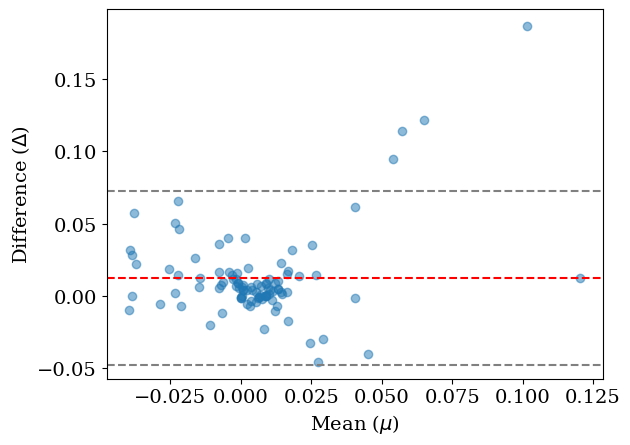

mean_diff is 0.013413449612046041


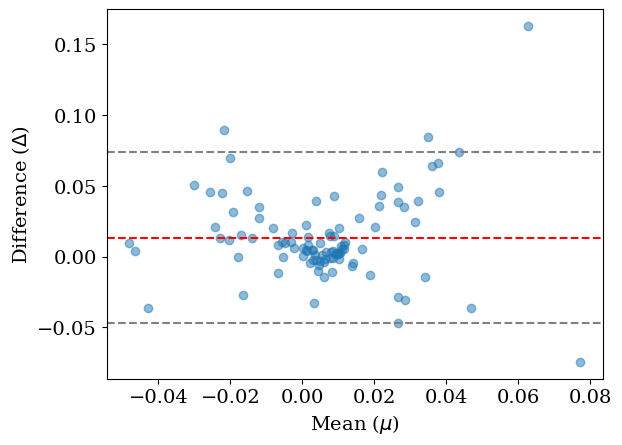

In [59]:
bland_altman_plot(test_1[sampled_indices,-1]*scale.values[0]+mean.values[0], pred_1[sampled_indices].detach().numpy().squeeze()*scale.values[0]+mean.values[0], 
                  path = f'../nnTraining/Results/bland_altman_{dt_name_1}.png')
bland_altman_plot(test_2[sampled_indices,-1]*scale.values[0]+mean.values[0], pred_2[sampled_indices].detach().numpy().squeeze()*scale.values[0]+mean.values[0], 
                  path = f'../nnTraining/Results/bland_altman_{dt_name_2}.png')

In [60]:
X_1 = torch.from_numpy(test_1[:, :-1]).float()
X_2 = torch.from_numpy(test_2[:, :-1]).float()

sensitivities_1 = sensitivity_analysis(model_1, X_1)
sensitivities_2 = sensitivity_analysis(model_2, X_2)

print("Sensitivities for 1:", sensitivities_1)
print("Sensitivities for 2:", sensitivities_2)

Sensitivities for 1: [100.           4.91249417   8.38185986  97.50318659  14.7016854
  16.76465567  15.62307493   4.90968709  18.0117896 ]
Sensitivities for 2: [ 12.05900039  33.44749105   5.99113027 100.           7.24719654
  11.7818685   24.40702051  14.2697517   19.89138786  31.96957492
  12.29865671  25.72294032]


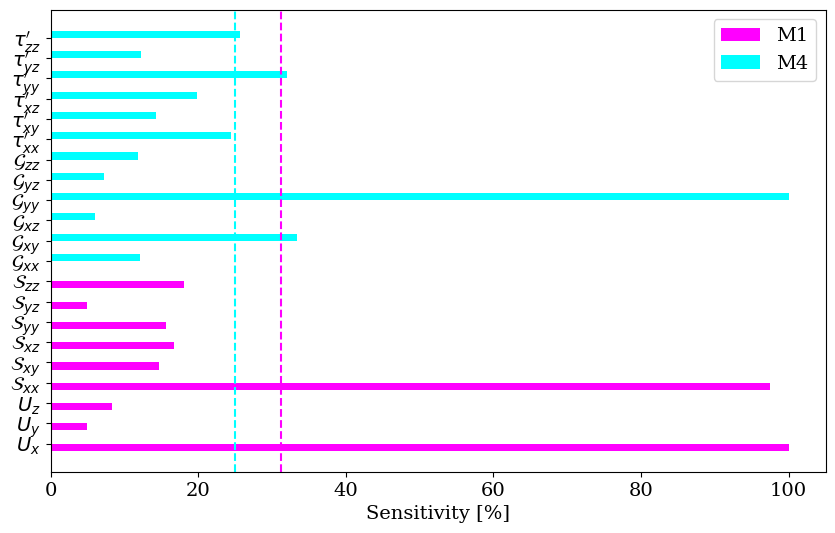

In [61]:
plot_sensitivities(features_name=[feature_names_1[:-1], feature_names_2[:-1]], 
                   sensitivities=[sensitivities_1, sensitivities_2], 
                   colors=['fuchsia', 'aqua'], #m3
                   #colors=['navy', 'red'], # m4
                   labels=[dt_name_1[0:2], dt_name_2[0:2]], 
                   path=f'../nnTraining/Results/Sensitivity_{dt_name_1[0:2]}_{dt_name_2}.png')


In [131]:
def scatterPlot(y_true, y_pred, path):
    plt.scatter(y_true, y_pred, edgecolor='white', color='red')
    plt.plot([0, 0], [-100, 100], '--', color='#929591')
    plt.plot([-100, 100], [0, 0], '--', color='#929591')
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.xlabel(r'$C_s$')
    plt.ylabel(r'$\tilde{C_s}$')
    plt.savefig(path)
    plt.show()
    
def densityPlot(y_true, y_pred, path):
    plt.hist(y_true, bins=8000, density=True, alpha=0.6, histtype=u'step', color='blue')
    plt.hist(y_pred, bins=8000, density=True, alpha=0.6, histtype=u'step', color='red')
    plt.xlim([-0.75, 0.75])
    plt.xlabel(r'$C_s$')
    plt.legend(['Ground Truth', 'MLP'])
    plt.savefig(path)
    plt.show()
    

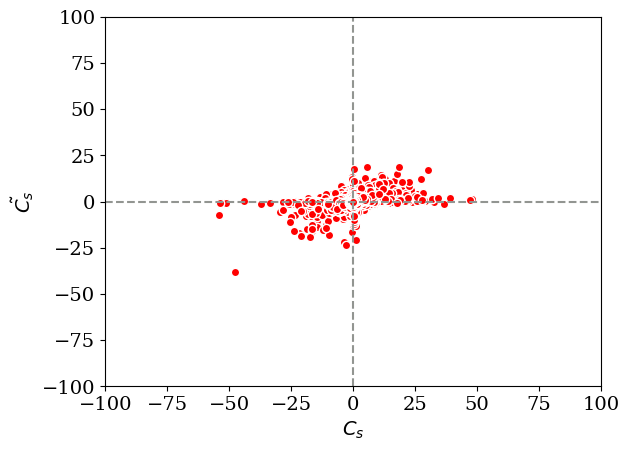

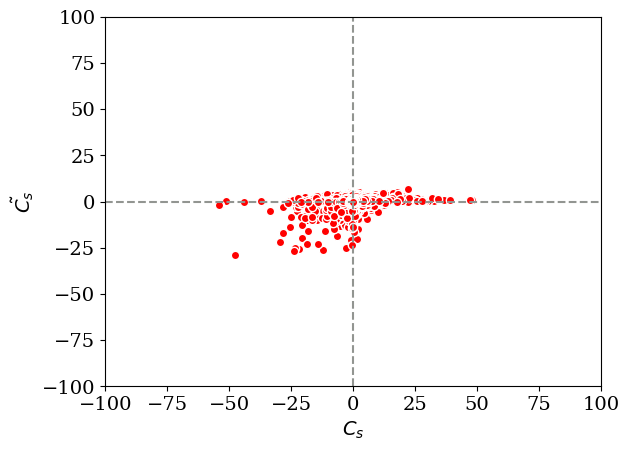

In [132]:
scatterPlot(test_1[:,-1], pred_1.detach().numpy().squeeze(), path=f'../nnTraining/Results/{dt_name_1}_correlation_unseen.png')
scatterPlot(test_2[:,-1], pred_2.detach().numpy().squeeze(), path=f'../nnTraining/Results/{dt_name_2}_correlation_unseen.png')

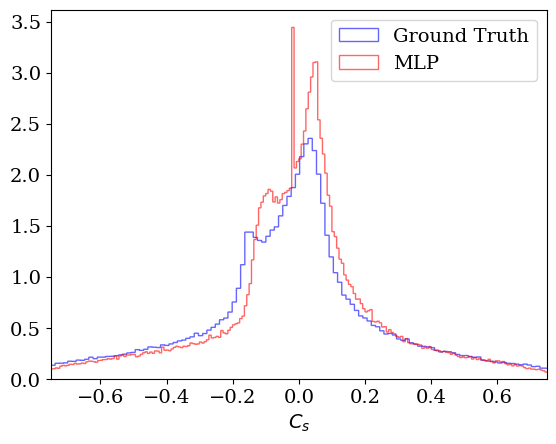

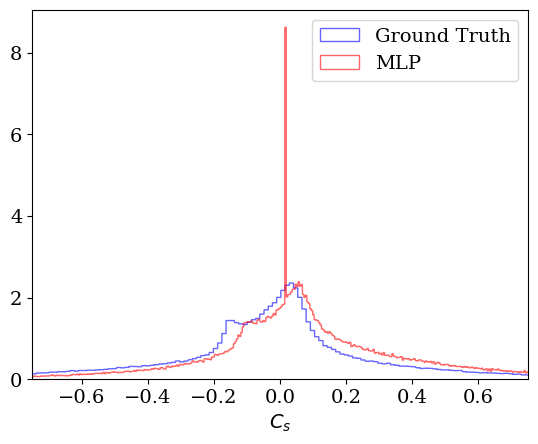

In [133]:
densityPlot(test_1[:,-1], pred_1.detach().numpy().squeeze(), path=f'../nnTraining/Results/{dt_name_1}_density_unseen.png')
densityPlot(test_2[:,-1], pred_2.detach().numpy().squeeze(), path=f'../nnTraining/Results/{dt_name_2}_density_unseen.png')

In [ ]:
coeff_determination(torch.from_numpy(test[:,-1][:40000]), pred[:40000])

In [ ]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation_unseen.png')

In [ ]:
plt.hist(test[:,-1], bins=8000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=8000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density_unseen.png')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Vertices of the rectangular cube based on your dimensions
vertices = np.array([[-6, -4, -4],
                     [10, -4, -4],
                     [10,  4, -4],
                     [-6,  4, -4],
                     [-6, -4,  4],
                     [10, -4,  4],
                     [10,  4,  4],
                     [-6,  4,  4]])

# List of sides' polygons of the cube
faces = [[vertices[i] for i in [0, 1, 5, 4]],
         [vertices[i] for i in [7, 6, 2, 3]],
         [vertices[i] for i in [0, 3, 7, 4]],
         [vertices[i] for i in [1, 2, 6, 5]],
         [vertices[i] for i in [2, 3, 7, 6]],
         [vertices[i] for i in [0, 1, 5, 4]]]

ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

ax.set_xlim([-6, 10])
ax.set_ylim([-4, 4])
ax.set_zlim([-4, 4])

plt.show()

# Auto scaling is done here
#scale = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#ax.auto_scale_xyz(*[[np.min(scale), np.max(scale)]]*3)

plt.savefig('rec_cube.png')


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# [Your existing code to define vertices and faces]

ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

# Set the limits of axes
ax.set_xlim([-6, 10])
ax.set_ylim([-4, 4])
ax.set_zlim([-4, 4])

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensions of the cube
x = [-6, 10]
y = [-4, 4]
z = [-4, 4]

# Discretization steps
Nx, Ny, Nz = 128, 64, 64

# Create a meshgrid
xx = np.linspace(x[0], x[1], Nx)
yy = np.linspace(y[0], y[1], Ny)
zz = np.linspace(z[0], z[1], Nz)
X, Y, Z = np.meshgrid(xx, yy, zz, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot just the edges of the cube for clarity
ax.plot3D([x[0], x[1], x[1], x[0], x[0]], [y[0], y[0], y[1], y[1], y[0]], [z[0], z[0], z[0], z[0], z[0]], color='k')  # Bottom
ax.plot3D([x[0], x[1], x[1], x[0], x[0]], [y[0], y[0], y[1], y[1], y[0]], [z[1], z[1], z[1], z[1], z[1]], color='k')  # Top
ax.plot3D([x[0], x[0]], [y[0], y[0]], [z[0], z[1]], color='k')  # Sides
ax.plot3D([x[1], x[1]], [y[0], y[0]], [z[0], z[1]], color='k')
ax.plot3D([x[1], x[1]], [y[1], y[1]], [z[0], z[1]], color='k')
ax.plot3D([x[0], x[0]], [y[1], y[1]], [z[0], z[1]], color='k')

# Set limits
ax.set_xlim(x[0], x[1])
ax.set_ylim(y[0], y[1])
ax.set_zlim(z[0], z[1])

plt.show()
